In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import optuna
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import softmax
from sklearn.linear_model import LogisticRegression
import numpy as np
import tensorflow as tf
import random
import xgboost as xgb

# Load the data
data = pd.read_csv('/content/drive/MyDrive/ufc_fight_predictor/data/interleaved_results_elo_hist_1_removed.csv');

data = data.dropna()

seed_value = 20
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()


data = data.drop_duplicates(subset=['EVENT', 'BOUT', 'FIGHTER'])

data['DATE'] = pd.to_datetime(data['DATE'])

# Filter the DataFrame to only include dates from 2010 to the current day
filtered_data = data[(data['DATE'] >= '2000-01-01') & (data['DATE'] <= pd.to_datetime('today'))]
#filtered_data = data[(data['DATE'] >= '2010-01-01') & (data['DATE'] <= pd.to_datetime('today'))

#filtered_data = data[(data['sex'] == 2)]
'''
# Define the main stats columns
main_stats_cols = [
    'age', 'HEIGHT', 'WEIGHT', 'REACH',
    'precomp_sigstr_pm', 'precomp_tdavg', 'precomp_sapm', 'precomp_subavg',
    'precomp_tddef', 'precomp_sigstr_perc', 'precomp_strdef', 'precomp_tdacc_perc',
    'precomp_totalacc_perc', 'precomp_headacc_perc', 'precomp_bodyacc_perc', 'precomp_legacc_perc',
    'precomp_distacc_perc','precomp_clinchacc_perc','precomp_groundacc_perc',
    'precomp_winsum', 'precomp_losssum','precomp_elo',
    'opp_age', 'opp_HEIGHT', 'opp_WEIGHT', 'opp_REACH',
    'opp_precomp_sigstr_pm', 'opp_precomp_tdavg', 'opp_precomp_sapm', 'opp_precomp_subavg',
    'opp_precomp_tddef', 'opp_precomp_sigstr_perc', 'opp_precomp_strdef', 'opp_precomp_tdacc_perc',
    'opp_precomp_totalacc_perc', 'opp_precomp_headacc_perc','opp_precomp_bodyacc_perc','opp_precomp_legacc_perc',
    'opp_precomp_distacc_perc','opp_precomp_clinchacc_perc','opp_precomp_groundacc_perc',
    'opp_precomp_winsum', 'opp_precomp_losssum', 'opp_precomp_elo',
    'precomp_sigstr_pm5', 'precomp_tdavg5', 'precomp_sapm5', 'precomp_subavg5',
    'precomp_tddef5', 'precomp_sigstr_perc5', 'precomp_strdef5', 'precomp_tdacc_perc5',
    'precomp_totalacc_perc5', 'precomp_headacc_perc5', 'precomp_bodyacc_perc5', 'precomp_legacc_perc5',
    'precomp_distacc_perc5','precomp_clinchacc_perc5','precomp_groundacc_perc5',
    'precomp_winsum5', 'precomp_losssum5','precomp_elo_change_5',
    'opp_precomp_sigstr_pm5', 'opp_precomp_tdavg5', 'opp_precomp_sapm5', 'opp_precomp_subavg5',
    'opp_precomp_tddef5', 'opp_precomp_sigstr_perc5', 'opp_precomp_strdef5', 'opp_precomp_tdacc_perc5',
    'opp_precomp_totalacc_perc5', 'opp_precomp_headacc_perc5','opp_precomp_bodyacc_perc5','opp_precomp_legacc_perc5',
    'opp_precomp_distacc_perc5','opp_precomp_clinchacc_perc5','opp_precomp_groundacc_perc5',
    'opp_precomp_winsum5', 'opp_precomp_losssum5','opp_precomp_elo_change_5',
    'precomp_sigstr_pm3', 'precomp_tdavg3', 'precomp_sapm3', 'precomp_subavg3',
    'precomp_tddef3', 'precomp_sigstr_perc3', 'precomp_strdef3', 'precomp_tdacc_perc3',
    'precomp_totalacc_perc3', 'precomp_headacc_perc3', 'precomp_bodyacc_perc3', 'precomp_legacc_perc3',
    'precomp_distacc_perc3','precomp_clinchacc_perc3','precomp_groundacc_perc3',
    'precomp_winsum3', 'precomp_losssum3','precomp_elo_change_3',
    'weight_avg3',
    'opp_precomp_sigstr_pm3', 'opp_precomp_tdavg3', 'opp_precomp_sapm3', 'opp_precomp_subavg3',
    'opp_precomp_tddef3', 'opp_precomp_sigstr_perc3', 'opp_precomp_strdef3', 'opp_precomp_tdacc_perc3',
    'opp_precomp_totalacc_perc3', 'opp_precomp_headacc_perc3','opp_precomp_bodyacc_perc3','opp_precomp_legacc_perc3',
    'opp_precomp_distacc_perc3','opp_precomp_clinchacc_perc3','opp_precomp_groundacc_perc3',
    'opp_precomp_winsum3', 'opp_precomp_losssum3','opp_precomp_elo_change_3'
]
'''

# Define the main stats columns
main_stats_cols = [
    'age', 'HEIGHT', 'WEIGHT', 'REACH', 'weightindex',
    'precomp_sigstr_pm', 'precomp_tdavg', 'precomp_sapm', 'precomp_subavg',
    'precomp_tddef', 'precomp_sigstr_perc', 'precomp_strdef', 'precomp_tdacc_perc',
    'precomp_totalacc_perc', 'precomp_headacc_perc', 'precomp_bodyacc_perc', 'precomp_legacc_perc',
    'precomp_distacc_perc','precomp_clinchacc_perc','precomp_groundacc_perc',
    'precomp_winsum', 'precomp_losssum','precomp_elo',
    'precomp_sigstr_pm5', 'precomp_tdavg5', 'precomp_sapm5', 'precomp_subavg5',
    'precomp_tddef5', 'precomp_sigstr_perc5', 'precomp_strdef5', 'precomp_tdacc_perc5',
    'precomp_totalacc_perc5', 'precomp_headacc_perc5', 'precomp_bodyacc_perc5', 'precomp_legacc_perc5',
    'precomp_distacc_perc5','precomp_clinchacc_perc5','precomp_groundacc_perc5',
    'precomp_winsum5', 'precomp_losssum5','precomp_elo_change_5',
    'precomp_sigstr_pm3', 'precomp_tdavg3', 'precomp_sapm3', 'precomp_subavg3',
    'precomp_tddef3', 'precomp_sigstr_perc3', 'precomp_strdef3', 'precomp_tdacc_perc3',
    'precomp_totalacc_perc3', 'precomp_headacc_perc3', 'precomp_bodyacc_perc3', 'precomp_legacc_perc3',
    'precomp_distacc_perc3','precomp_clinchacc_perc3','precomp_groundacc_perc3',
    'precomp_winsum3', 'precomp_losssum3','precomp_elo_change_3',
    'weight_avg3',
    'opp_precomp_sigstr_pm5', 'opp_precomp_tdavg5', 'opp_precomp_sapm5', 'opp_precomp_subavg5',
    'opp_precomp_tddef5', 'opp_precomp_sigstr_perc5', 'opp_precomp_strdef5', 'opp_precomp_tdacc_perc5',
    'opp_precomp_totalacc_perc5', 'opp_precomp_headacc_perc5','opp_precomp_bodyacc_perc5','opp_precomp_legacc_perc5',
    'opp_precomp_distacc_perc5','opp_precomp_clinchacc_perc5','opp_precomp_groundacc_perc5',
    'opp_precomp_winsum5', 'opp_precomp_losssum5','opp_precomp_elo_change_5',
    'opp_age', 'opp_HEIGHT', 'opp_WEIGHT', 'opp_REACH','opp_weightindex',
    'opp_precomp_sigstr_pm', 'opp_precomp_tdavg', 'opp_precomp_sapm', 'opp_precomp_subavg',
    'opp_precomp_tddef', 'opp_precomp_sigstr_perc', 'opp_precomp_strdef', 'opp_precomp_tdacc_perc',
    'opp_precomp_totalacc_perc', 'opp_precomp_headacc_perc','opp_precomp_bodyacc_perc','opp_precomp_legacc_perc',
    'opp_precomp_distacc_perc','opp_precomp_clinchacc_perc','opp_precomp_groundacc_perc',
    'opp_precomp_winsum', 'opp_precomp_losssum', 'opp_precomp_elo',
    'opp_precomp_sigstr_pm3', 'opp_precomp_tdavg3', 'opp_precomp_sapm3', 'opp_precomp_subavg3',
    'opp_precomp_tddef3', 'opp_precomp_sigstr_perc3', 'opp_precomp_strdef3', 'opp_precomp_tdacc_perc3',
    'opp_precomp_totalacc_perc3', 'opp_precomp_headacc_perc3','opp_precomp_bodyacc_perc3','opp_precomp_legacc_perc3',
    'opp_precomp_distacc_perc3','opp_precomp_clinchacc_perc3','opp_precomp_groundacc_perc3',
    'opp_precomp_winsum3', 'opp_precomp_losssum3','opp_precomp_elo_change_3','opp_weight_avg3'
]
elo_cols = ['precomp_elo', 'precomp_elo_change_3', 'opp_precomp_elo','opp_precomp_elo_change_3']
# For now, we use the main stats columns; later, we can define columns for the last 3 and 5 fights
features_cols = main_stats_cols # This can be replaced or extended with other stats
#elo_cols = ['precomp_elo', 'opp_precomp_elo']



# Filter the dataset for the relevant features and target
X = filtered_data[features_cols]
y = filtered_data['result']

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [ ]:
print('x_tr:', X_train)
print('x_ts:', X_test)

x_tr:       age  HEIGHT  WEIGHT  REACH  weightindex  precomp_sigstr_pm  \
5850  0.0    68.0   135.0   71.0            6                  5   
3361  0.0    74.0   240.0   80.0           12                  4   
3111  0.0    75.0   205.0   80.0           11                  2   
3619  0.0    70.0   145.0   70.0            7                 10   
1448  0.0    72.0   185.0   74.0           10                  2   
...   ...     ...     ...    ...          ...                ...   
5994  0.0    68.0   145.0   72.0            7                  6   
3989  0.0    67.0   135.0   67.0            3                  1   
7172  0.0    72.0   185.0   74.0           10                  2   
7503  0.0    70.0   155.0   74.0            8                  3   
4441  0.0    61.0   115.0   63.0            1                  2   

      precomp_tdavg  precomp_sapm  precomp_subavg  precomp_tddef  ...  \
5850              1             3               0              1  ...   
3361              3            

In [ ]:
# Scale the feature data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



dnn_model = models.Sequential([
    layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.05), input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])


dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model

dnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size = 32, validation_split=0.2, shuffle=False)

# Evaluate the model
loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5192 - loss: 1.2769 - val_accuracy: 0.5289 - val_loss: 0.7536
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5409 - loss: 0.7246 - val_accuracy: 0.5935 - val_loss: 0.6925
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6166 - loss: 0.6889 - val_accuracy: 0.6231 - val_loss: 0.6860
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 0.6789 - val_accuracy: 0.6421 - val_loss: 0.6724
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6777 - loss: 0.6565 - val_accuracy: 0.6801 - val_loss: 0.6431
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7223 - loss: 0.6161 - val_accuracy: 0.7166 - val_loss: 0.6012
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7455 - loss: 0.5715 - val_accuracy: 0.7363 - val_loss: 0.5682
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7552 - loss: 0.5435 - val_accuracy: 0

In [ ]:
predictions = dnn_model.predict(X_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
import shap

explainer = shap.Explainer(dnn_model, X)

In [ ]:
shap_values = explainer(X)  # Calculate SHAP values for 10 samples


PermutationExplainer explainer:   4%|▍         | 335/8220 [00:18<12:15, 10.72it/s]


KeyboardInterrupt: 

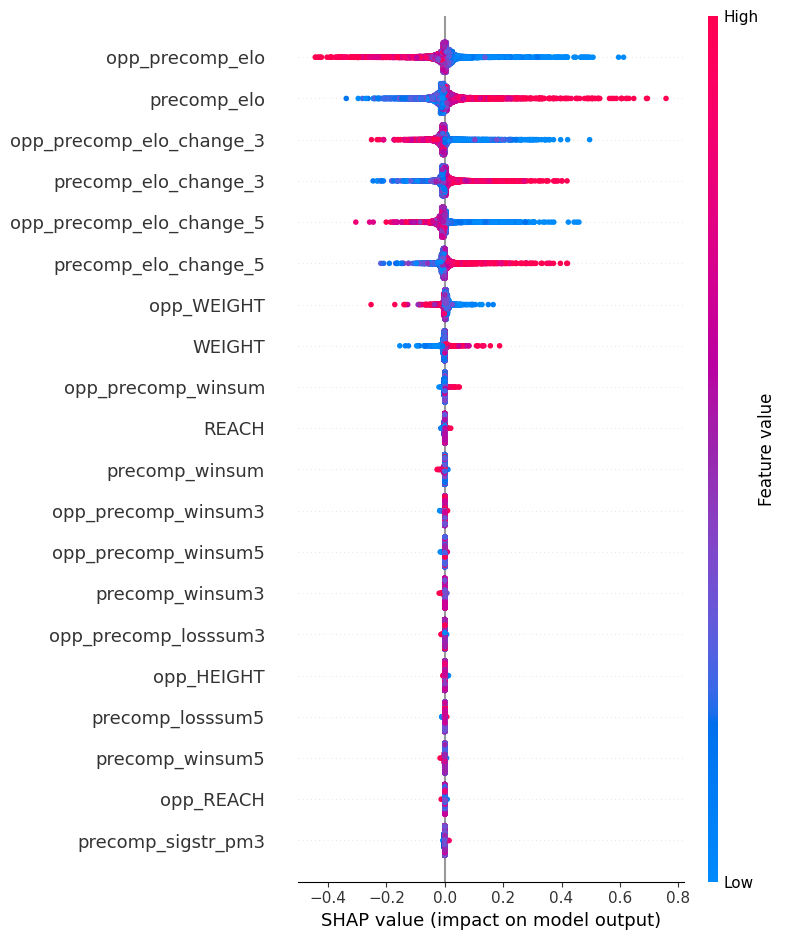

In [ ]:
shap.summary_plot(shap_values, X, feature_names=features_cols)

In [ ]:
print(predictions[1:20])

[[0.9306488 ]
 [0.93432146]
 [0.21455443]
 [0.9005126 ]
 [0.06448437]
 [0.89240825]
 [0.14634764]
 [0.81588745]
 [0.02804109]
 [0.79009324]
 [0.92126137]
 [0.31476513]
 [0.12199755]
 [0.9066424 ]
 [0.62278146]
 [0.7983929 ]
 [0.04727233]
 [0.26171094]
 [0.04713148]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

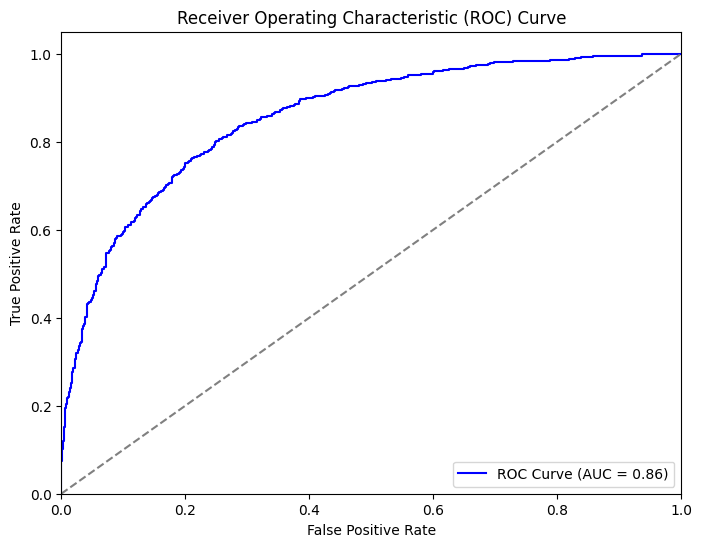

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Weight Class Predictions
- 115(2): 59.4%: 69 examples
- 125(3): 58.1%: 43 examples
- 135W(4): 100%: 2 examples
- 125M(5): 71.2%: 66 examples
- 135M(6): 81.1%: 143 examples
- 145M(7): 72.2%: 151 examples
- 155(8): 69.3%: 231 examples
- 170(9): 75.7%: 263 examples
- 185(10): 73.5%: 196 examples
- 205(11): 60.7%: 135 examples
- 265(12): 63.6% 118 examples

# XGboost
- takes about 5 minutes to run

In [ ]:
# Adding 'opp_' prefix to every feature in the main_stats_cols array
main_stats_cols = [
    'age', 'HEIGHT', 'WEIGHT', 'REACH', 'weightindex',
    'postcomp_sigstr_pm', 'postcomp_tdavg', 'postcomp_sapm', 'postcomp_subavg',
    'postcomp_tddef', 'postcomp_sigstr_perc', 'postcomp_strdef', 'postcomp_tdacc_perc',
    'postcomp_totalacc_perc', 'postcomp_headacc_perc', 'postcomp_bodyacc_perc', 'postcomp_legacc_perc',
    'postcomp_distacc_perc','postcomp_clinchacc_perc','postcomp_groundacc_perc',
    'postcomp_winsum', 'postcomp_losssum','postcomp_elo',
    'postcomp_sigstr_pm5', 'postcomp_tdavg5', 'postcomp_sapm5', 'postcomp_subavg5',
    'postcomp_tddef5', 'postcomp_sigstr_perc5', 'postcomp_strdef5', 'postcomp_tdacc_perc5',
    'postcomp_totalacc_perc5', 'postcomp_headacc_perc5', 'postcomp_bodyacc_perc5', 'postcomp_legacc_perc5',
    'postcomp_distacc_perc5','postcomp_clinchacc_perc5','postcomp_groundacc_perc5',
    'postcomp_winsum5', 'postcomp_losssum5','postcomp_elo_change_5',
    'postcomp_sigstr_pm3', 'postcomp_tdavg3', 'postcomp_sapm3', 'postcomp_subavg3',
    'postcomp_tddef3', 'postcomp_sigstr_perc3', 'postcomp_strdef3', 'postcomp_tdacc_perc3',
    'postcomp_totalacc_perc3', 'postcomp_headacc_perc3', 'postcomp_bodyacc_perc3', 'postcomp_legacc_perc3',
    'postcomp_distacc_perc3','postcomp_clinchacc_perc3','postcomp_groundacc_perc3',
    'postcomp_winsum3', 'postcomp_losssum3','postcomp_elo_change_3',
    'weight_avg3',
]
elo_col = ['postcomp_elo', 'postcomp_elo_change_3']

# Adding 'opp_' prefix
opp_main_stats_cols = ['opp_' + col for col in main_stats_cols]
opp_main_stats_cols

def get_most_recent_fight_stats(data, fighter_name):
    fighter_data = data[data['FIGHTER'] == fighter_name]
    if fighter_data.empty:
        raise ValueError(f"No fights found for fighter {fighter_name}")
    recent_fight = fighter_data.iloc[-1]  # Get the most recent fight
    stats = recent_fight[main_stats_cols]
    return stats.values.astype(np.float32)

def predict_fight_outcome(model, data, fighter_a, fighter_b):
    stats_a = get_most_recent_fight_stats(data, fighter_a);
    stats_b = get_most_recent_fight_stats(data, fighter_b);

    input_1 = np.concatenate([stats_a, stats_b]).reshape(1, -1).squeeze();
    input_1 = scaler.transform([input_1]).reshape(1, -1);
    input_2 = np.concatenate([stats_b, stats_a]).reshape(1, -1).squeeze();
    input_2 = scaler.transform([input_2]).reshape(1, -1);

    prediction_1 = model.predict(input_1);
    prediction_2 = model.predict(input_2);

    print('Prediction 1:', prediction_1)
    print('Prediction 2:', prediction_2)

    return prediction_1, prediction_2
# Example usage:

data = data.iloc[::-1]
fighter_a = 'Brandon Moreno'
fighter_b = 'Brandon Royval'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Yair Rodriguez'
fighter_b = 'Brian Ortega'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Vitor Petrino'
fighter_b = 'Tyson Pedro'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Dustin Poirier'
fighter_b = 'Benoit Saint Denis'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Sean O\'Malley'
fighter_b = 'Marlon Vera'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Jack Della Maddalena'
fighter_b = 'Gilbert Burns'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Israel Adesanya'
fighter_b = 'Dricus Du Plessis'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Steve Erceg'
fighter_b = 'Kai Kara-France'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)

fighter_a = 'Kai Kara-France'
fighter_b = 'Steve Erceg'
predict_fight_outcome(dnn_model, data, fighter_a, fighter_b)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.94940174]]
Prediction 2: [[0.9494976]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.94928473]]
Prediction 2: [[0.9494933]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.9494778]]
Prediction 2: [[0.94953597]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.94950557]]
Prediction 2: [[0.9495121]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.94944674]]
Prediction 2: [[0.94938946]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction 1: [[0.94947845]]
Prediction 2: [[0.9494096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.94945997]]
Prediction 2: [[0.9494614]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction 1: [[0.9494522]]
Prediction 2: [[0.9494303]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 1: [[0.9494303]]
Prediction 2: [[0.9494522]]


(array([[0.9494303]], dtype=float32), array([[0.9494522]], dtype=float32))

In [ ]:
# print out the activatoins and weights for each layer
for layer in dnn_model.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    print(f"Weights shape: {weights[0].shape}")
    print(f"Weights values: {weights[0]}")
    print(f"Biases shape: {weights[1].shape}")
    print(f"Biases values: {weights[1]}")


print('x_test:', X_test)
predictions = dnn_model.predict(X_test)
print(f"Predictions:\n{predictions}")
predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary class labels
print(f"Predictions:\n{predictions_binary}")

Layer: dense
Weights shape: (118, 10)
Weights values: [[-8.0470564e-03 -1.5447674e-02 -2.7185190e-43 ... -2.5108352e-02
   2.5381628e-02 -1.0721523e-03]
 [ 5.4709041e-03  3.1862035e-04 -4.6382979e-42 ... -3.6928586e-03
  -3.0945793e-03  5.6680321e-04]
 [ 1.7746745e-02  7.9696355e-03  5.3263355e-42 ... -1.3166985e-02
  -2.2750340e-02  4.9276403e-03]
 ...
 [-3.7604958e-02 -3.2795291e-02  6.5931093e-42 ... -3.4717973e-02
   6.7315295e-02 -1.4629676e-02]
 [-4.7825351e-02 -7.3342241e-02  7.0064923e-44 ... -5.4282900e-02
   1.3241431e-01 -1.5909409e-02]
 [-4.2559761e-03 -5.0352314e-03 -2.7465450e-42 ... -9.1007734e-03
   4.6127844e-03 -2.5799961e-03]]
Biases shape: (10,)
Biases values: [ 0.27875695  0.31109533 -0.06620998  0.44852576 -0.12122895  0.29543084
  0.18082994  0.15195425  0.4961636   0.20634986]
Layer: dense_1
Weights shape: (10, 10)
Weights values: [[-0.27218553  0.3358853   0.38707724  0.15582421  0.27176338  1.192736
   0.9772457  -0.71320856  0.70844275  1.0146779 ]
 [-1.05982

In [ ]:
def predict_outcome(fighter_data):
    fighter_data_scaled = scaler.transform([fighter_data])
    prediction = dnn_model.predict(fighter_data_scaled)
    return prediction

